# Cox Proportional Hazards Regression Model Process

## 1.	In our multivariate case, we have the null hypotheses for each variable that survival time is equal across each variable.
We will use the Stanford heart transplant dataset which lists survival of the patients waiting for transplant in the Stanford heart transplant program. We will use age, year, surgery, and transplant status as predictors for the hazard ratio for stopping, which ends either in death or transplant.

In [62]:
sm.datasets.get_rdataset('heart', package='survival').data['transplant'].value_counts()

0    103
1     69
Name: transplant, dtype: int64

In [7]:
import statsmodels.api as sm

data = sm.datasets.get_rdataset('heart', package='survival').data
### Survival of patients on the waiting list for the Stanford heart transplant program.
# surgery:	prior bypass surgery (prior bypass surgery 1=yes)
# age:	age (in years)
# transplant:	transplant indicator (received transplant 1=yes)
# start, stop, event:	Entry and exit time and status for this interval of time
# age:	age-48 years
# year:	year of acceptance (in years after 1 Nov 1967)
# id:	patient id
train_data = data.iloc[0:171]
test_data = data.iloc[171:]

exog=train_data[['age','year','surgery']]#train_data[['age','year','surgery','transplant']]
endog=train_data['stop']

In [26]:
data.head()

,start,stop,event,age,year,surgery,transplant,id
0,0.0,50.0,1,-17.155373,0.123203,0,0,1
1,0.0,6.0,1,3.835729,0.254620,0,0,2
2,0.0,1.0,0,6.297057,0.265572,0,0,3
3,1.0,16.0,1,6.297057,0.265572,0,1,3
4,0.0,36.0,0,-7.737166,0.490075,0,0,4


## 2. Estimate survival using the Kaplan-Meier Estimate, which will account for right-censoring in the data.
Right-censoring occurs when the event variable is equal to one. We can see 171 enter at point 0. On the first day (stop=1), coresponding to index column "event_at" equal to 1, we have right-censoring for three patients. We observed the event take place for one patient (observed=1) and the other two patients were censored. Below, we show the corresponding data. Patient with id 45 stops, but restarts the same day, then survives until day 45. Same for patient id 3, which survives until day 16. Patient id = 15 does not re-enter for follow-up; we assume since they did not receive a transplant they did not survive. It's also noted patient 3 had a previous heart surgery so may have been at elevated risk for declined survival rate.

In [46]:
data['stop'].max()

1800.0

In [84]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

KaplanMeierFitter = KaplanMeierFitter()
# durations corresponds to survival time
# event_observed corresponds to whether the transplant or death occured
KaplanMeierFitter.fit(durations=data['stop'], event_observed=data['event'])
KaplanMeierFitter.event_table.reset_index().to_clipboard()
KaplanMeierFitter.event_table.reset_index()

,event_at,removed,observed,censored,entrance,at_risk
0,0.0,0,0,0,172,172
1,1.0,3,1,2,0,172
2,2.0,6,3,3,0,169
3,3.0,6,3,3,0,163
4,4.0,2,0,2,0,157
...,...,...,...,...,...,...
107,1401.0,1,0,1,0,5
108,1408.0,1,0,1,0,4
109,1572.0,1,0,1,0,3
110,1587.0,1,0,1,0,2


In [16]:
train_data.loc[train_data['stop']==1].to_clipboard(index=False)
train_data.loc[train_data['stop']==1]

,start,stop,event,age,year,surgery,transplant,id
2,0.0,1.0,0,6.297057,0.265572,0,0,3
21,0.0,1.0,1,5.815195,0.991102,1,0,15
70,0.0,1.0,0,-11.816564,3.263518,0,0,45


In [18]:
train_data.loc[train_data['id'].isin([3, 15,45])].to_clipboard(index=False)
train_data.loc[train_data['id'].isin([3, 15,45])]

,start,stop,event,age,year,surgery,transplant,id
2,0.0,1.0,0,6.297057,0.265572,0,0,3
3,1.0,16.0,1,6.297057,0.265572,0,1,3
21,0.0,1.0,1,5.815195,0.991102,1,0,15
70,0.0,1.0,0,-11.816564,3.263518,0,0,45
71,1.0,45.0,1,-11.816564,3.263518,0,1,45


### To verify patient 45 is the only patient stopped on day 45, we look to see the number who were removed on day 45, which is one patient. We can also see patient 45 received a heart transplant on day index 45.

In [22]:
train_data.loc[train_data['stop']==45].to_clipboard()
train_data.loc[train_data['stop']==45]

,start,stop,event,age,year,surgery,transplant,id
71,1.0,45.0,1,-11.816564,3.263518,0,1,45


In [20]:
KaplanMeierFitter.event_table.loc[KaplanMeierFitter.event_table.index==45.0].to_clipboard()
KaplanMeierFitter.event_table.loc[KaplanMeierFitter.event_table.index==45.0]

,removed,observed,censored,entrance,at_risk
event_at,,,,,
45.0,1,1,0,0,87


In [86]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


KaplanMeierFitter_n = KaplanMeierFitter()
KaplanMeierFitter_y = KaplanMeierFitter()

KaplanMeierFitter_n.fit(durations=data.loc[data['transplant']==0]['stop'], event_observed=data.loc[data['transplant']==0]['event'], label='no transplant')
KaplanMeierFitter_y.fit(durations=data.loc[data['transplant']==1]['stop'], event_observed=data.loc[data['transplant']==1]['event'], label='transplant');

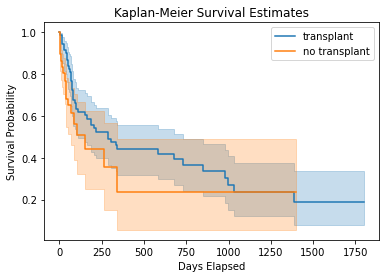

In [88]:
KaplanMeierFitter_y.plot()
KaplanMeierFitter_n.plot()
plt.ylabel('Survival Probability')
plt.xlabel('Days Elapsed')
plt.title('Kaplan-Meier Survival Estimates')
plt.savefig('KaplanMeierEstimation.png', dpi=300, facecolor='w', bbox_inches = "tight");

In [89]:
print('Non-Transplant Survival Probability at day 300: ', KaplanMeierFitter_n.predict(300))
print('Transplant Survival Probability at day 300: ', KaplanMeierFitter_y.predict(300))

Non-Transplant Survival Probability at day 300:  0.3545098269168237
Transplant Survival Probability at day 300:  0.4911598783770023


## 3. Log-rank test to determine if survivor curves are statistically different.
At this step, we investigate if there is any statistical significance in survival between transplant and non-transplant groups. If there is no statistical significance, it would not be useful to understand the relationships between the covariates and their impacts on survival. We looked at contingency table analysis using the Chi-Square Test of Independence earlier in the book. This is essentially the log-rank test here, where we compare the survival distributions of the two groups (transplant vs. non-transplant). We use this approach because the data is right-censored, and thus right-skewed; as such, we are working with non-parametric distributions. The null hypothesis is that the hazard ratio between the two groups is equal to 1, which would mean they are equal in terms of survival or hazard risk.

In [94]:
from lifelines.statistics import logrank_test

lr_results = logrank_test(durations_A=data.loc[data['transplant']==0]['stop'],
                          durations_B=data.loc[data['transplant']==1]['stop'],
                          event_observed_A=data.loc[data['transplant']==0]['event'],
                          event_observed_B=data.loc[data['transplant']==1]['event'])

lr_results

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.03 0.04      4.48

In [99]:
print(lr_results.null_distribution)

chi squared


In [105]:
lr_results.summary.to_clipboard()
lr_results.summary

,test_statistic,p,-log2(p)
0,4.02651,0.044791,4.480663


## 4. Cox Proportional-Hazards Regression
Here, we run the Cox Proportional Hazards test and analyze the p-values and confidence intervals for the terms included to identify if they have statistical significance with respect to influence over survival rate. We look at the hazard ratio to determine any effects they have provide.
<br>
<br>
We can see three of our four terms are significant at the 5% level of significance for predicting survival; our surgery variable does not appear to be based on the p-value. The 95% confidence interval for surgery does not contain 0, however, which suggests statistical significance. The difference is because the p-value is calculated based on the test statistic with respect to the critical value, which are estimated using the log of the hazard ratio and the confidence interval is based on the hazard ratio itself. This discrepancy could mean the surgery variable is significant, but also that it may not be. Since we aren’t statistically certain, we should err on the side of caution and not consider it useful when predicting future survival.<br>
<br>
Note that exp(coef) corresponds to the hazard ratio and coef is the log of the hazard ratio. This follows the equation we provided earlier for the expected hazard value at base time, t.
<br>
<br>
We can say, based on the hazard ratio (exp(coef)) of 1.03, that a single unit increase in age over age 48 results in an increase of hazard by a factor of 1.03, or 3%. With respect to our transplant variable, we can say with a 95% level of confidence that having the heart transplant decreased hazard by a factor of 0.54, which is equivalent to 46%.

In [107]:
from lifelines import CoxPHFitter

CoxPHFitter = CoxPHFitter()

CoxPHFitter.fit(df=train_data[['age','year','surgery','transplant','stop','event']], duration_col='stop', event_col='event')
CoxPHFitter.print_summary()

<lifelines.CoxPHFitter: fitted with 171 total observations, 97 right-censored observations>
             duration col = 'stop'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 171
number of events observed = 74
   partial log-likelihood = -298.47
         time fit was run = 2023-03-17 16:23:26 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
age          0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
year        -0.16       0.85       0.07            -0.30            -0.02                 0.74                 0.98
surgery     -0.64       0.53       0.37            -1.36             0.08                 0.26                 1.08
transplant  -0.62       0.54       0.27            -1.15            -0.08                 0.32                 0.92

             cmp to     z    p   -log2(p)
covariate                                
age            0.00  2.35 0.02       5.74
year           0.00 -2.25 0.02       5.35
surgery        0.00 -1.74 0.08       3.62
transplant     0.00 -2.26 0.02       5.41
---
Concordance = 0.67
Partial AIC = 604.95
log-likelihood ratio test = 21.22 on 4 df
-log2(p) of ll-ratio test = 11.77

Below, we can see age, which applies only a 3% increase in hazard does not explain much variance in the results. The age range spans roughly 9 years throuh 64 years of age. Without other covariates, we cannot say exactly why this might be, but including more covariates could prove helpful in understanding this variable more. Of the significant variables, transplant has notably the largest impact on survival outcomes. 

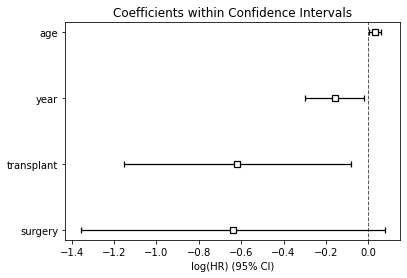

In [121]:
plt.title('Coefficients within Confidence Intervals')
CoxPHFitter.plot()
plt.savefig('Coefficients.png', dpi=300, facecolor='w', bbox_inches = "tight");

We can see the assumption of a constant hazard ratio between all patients in the survival function plot in Figure 14.x, below. This is why it is important to prevent informative censoring. Let's assume this assumption is met.

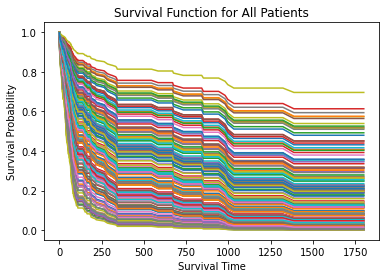

In [121]:
CoxPHFitter.predict_survival_function(train_data[['age','year','surgery','transplant']]).plot()
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function for All Patients')
plt.legend().set_visible(False)
plt.savefig('SurvivalFunctionAll.png', dpi=300, facecolor='w', bbox_inches = "tight");

We can again see this with the survival function of the average in the next figure, Figure 14.x as well as for our test (holdout) patient in the following figure, Figure 14.x as well.

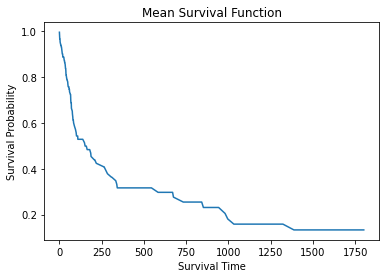

In [122]:
CoxPHFitter.predict_survival_function(train_data[['age','year','surgery','transplant']].mean()).plot()
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.title('Mean Survival Function')
plt.legend().set_visible(False)
plt.savefig('SurvivalFunctionMean.png', dpi=300, facecolor='w', bbox_inches = "tight");

## 5. Predict using Cox Proportional Hazards
Under the assumption the requirements for the Cox Proportional Hazards model can be assumed met, we can then use our variables for our holdout data to predict the survival function for that patient, patient 171, below, in Figure 14.x.

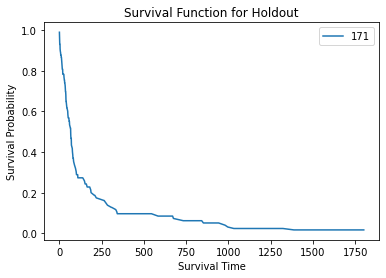

In [123]:
CoxPHFitter.predict_survival_function(test_data[['age','year','surgery','transplant']]).plot()
plt.xlabel('Survival Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function for Holdout')
plt.savefig('SurvivalFunctionHoldout.png', dpi=300, facecolor='w', bbox_inches = "tight");

In [119]:
CoxPHFitter.predict_survival_function(test_data[['age','year','surgery','transplant','stop','event']])

,171
1.0,0.990153
2.0,0.960369
3.0,0.930393
4.0,0.930393
4.5,0.930393
...,...
1401.0,0.016530
1408.0,0.016530
1572.0,0.016530
1587.0,0.016530
